# Metrics for training + validation

In [ ]:
#y_true = y_test
#y_pred = test_preds
#def dice_coef(y_true, y_pred, smooth=1):
#    y_true_f = K.flatten(y_true)
#    y_pred_f = K.flatten(y_pred)
#    intersection = K.sum(y_true_f * y_pred_f)
#    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


#def dice_coef_loss(y_true, y_pred):
#    return -dice_coef(y_true, y_pred)


#hi = y_test / 255
#hi = K.flatten(hi)
#hi = tf.convert_to_tensor(hi, dtype=None)
#pred = test_preds
#pred = K.flatten(pred)
#pred = tf.convert_to_tensor(test_preds, dtype=None)

def dice_coef(a, b):
          #  hi = K.hi
          #  hi = hi / 255
    
          #    hi = tf.convert_to_tensor(hi, dtype=None)
          #    pred = tf.convert_to_tensor(test_preds, dtype=None)
    hi = a
  #  hi = tf.dtypes.cast(hi, tf.float32)
    pred = b
    hi = K.flatten(hi)
    pred = K.flatten(pred)
    upper_part = 2 * K.sum((hi * pred))
    lower_part = K.sum(hi + pred)
    dice = upper_part / lower_part
    return dice

def dice_coef_loss(a, b):
    loss = 1 - dice_coef(a, b)
    return loss

def jaccard_index(a, b):
    hi = a 
    pred = b
    hi = K.flatten(hi)
    pred = K.flatten(pred)
    numerator = K.sum(hi * pred)
    denominator = K.sum((hi + pred) - (hi * pred))
    iou = numerator / denominator
    return iou

# Libraries

In [ ]:
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

# Ternausnet

In [ ]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19

"""
A Keras implementation of TernausNet16: 
https://arxiv.org/abs/1801.05746
https://github.com/ternaus/TernausNet
The architecture is very similar to the original U-net paper:
https://arxiv.org/abs/1505.04597
The key differences are:
- A VGG16 architecture is used for encoder, pretrained on ImageNet
- No batchnorm used
- No dropout used
- Shortcut concatenations are mismatched on number of filters meaning that 
  a larger number of filters is used in decoder.
"""


def decoder_block_ternausV2(inputs, mid_channels, out_channels):
    """
    Decoder block as proposed for TernausNet16 here: 
    https://arxiv.org/abs/1801.05746
    See DecoderBlockV2 here:
    https://github.com/ternaus/TernausNet/blob/master/unet_models.py
    - Concatenate u-net shortcut to input pre-upsample
    - Bilinear upsample input to double Height and Width dimensions
    - Note: The original ternausNet implementation includes option for 
      deconvolution instead of bilinear upsampling. Omitted here because I 
      couldn't find a meaningful performance comparison
    """
    
    conv_kwargs = dict(
        activation='relu',
        padding='same',
        kernel_initializer='he_normal',
        data_format='channels_last'  # (batch, height, width, channels)
    )

    x = UpSampling2D(size=(2, 2))(inputs) # interpolation='bilinear' doesn't work?
    x = Conv2D(mid_channels, 3, **conv_kwargs)(x)
    x = Conv2D(out_channels, 3, **conv_kwargs)(x)
    return x


# INTENDED API
# ------------------------------------------------------------------------------

def ternausNet16(input_size=(256, 256, 3), output_channels=3):
    """
    A Keras implementation of TernausNet16: 
    https://arxiv.org/abs/1801.05746
    https://github.com/ternaus/TernausNet
    """

    # input 
    # convert 1 channel grayscale to 3 channels if needed
    inputs = Input(input_size)
    if input_size[-1] < 3:
        x = Conv2D(3, 1)(inputs)                         # add channels
        input_shape = (input_size[0], input_size[0], 3)  # update input size
    else:
        x = inputs
        input_shape = input_size
    
    # Load pretrained VGG, conv layers include relu activation
    encoder = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
       
    # (None, 256, 256, 3)
    e1 = encoder.get_layer(name='block1_conv1')(x)
    e1 = encoder.get_layer(name='block1_conv2')(e1)
    # (None, 256, 256, 64)
    e2 = MaxPooling2D(pool_size=(2, 2))(e1)
    e2 = encoder.get_layer(name='block2_conv1')(e2)
    e2 = encoder.get_layer(name='block2_conv2')(e2)
    # (None, 128, 128, 128)
    e3 = MaxPooling2D(pool_size=(2, 2))(e2)
    e3 = encoder.get_layer(name='block3_conv1')(e3)
    e3 = encoder.get_layer(name='block3_conv2')(e3)
    e3 = encoder.get_layer(name='block3_conv3')(e3)
    # (None, 64, 64, 256)
    e4 = MaxPooling2D(pool_size=(2, 2))(e3)
    e4 = encoder.get_layer(name='block4_conv1')(e4)
    e4 = encoder.get_layer(name='block4_conv2')(e4)
    e4 = encoder.get_layer(name='block4_conv3')(e4)
    # (None, 32, 32, 512)
    e5 = MaxPooling2D(pool_size=(2, 2))(e4)
    e5 = encoder.get_layer(name='block5_conv1')(e5)
    e5 = encoder.get_layer(name='block5_conv2')(e5)
    e5 = encoder.get_layer(name='block5_conv3')(e5)
    # (None, 16, 16, 512)
    center = MaxPooling2D(pool_size=(2, 2))(e5)
    # (None, 8, 8, 512)
    center = decoder_block_ternausV2(center, 512, 256)
    # (None, 16, 16, 256)
    d5 = concatenate([e5, center], axis=3)
    d5 = decoder_block_ternausV2(d5, 512, 256)
    # (None, 32, 32, 256)
    d4 = concatenate([e4, d5], axis=3)
    d4 = decoder_block_ternausV2(d4, 512, 128)
    # (None, 64, 64, 128)
    d3 = concatenate([e3, d4], axis=3)
    d3 = decoder_block_ternausV2(d3, 256, 64)
    # (None, 128, 128, 64)
    d2 = concatenate([e2, d3], axis=3)
    d2 = decoder_block_ternausV2(d2, 128, 64)
    # (None, 256, 256, 64)
    # Note: no decoder block used at end
    d1 = concatenate([e1, d2], axis=3)
    #initializer = tf.keras.initializers.LecunUniform()
    d1 = Conv2D(32, 3, padding='same', kernel_initializer='he_normal')(d1)
    #'he_normal'
    d1 = ReLU()(d1)
    # (None, 256, 256, 32)

    # Output
    #if output_channels > 1:
        # untested
    #    op = tf.nn.log_softmax_v2(d1, axis=3)
    #else:
        
    op = Conv2D(output_channels, 1)(d1)
    op = Activation('sigmoid')(op)  # note: ternaus excludes

    # Build
    model = Model(inputs=[inputs], outputs=[op])
    
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.5,
    staircase=True)
    
    opt = keras.optimizers.Adam(learning_rate=0.0001)

    #model.compile(optimizer='adam', loss='binary_crossentropy')
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[dice_coef, jaccard_index])
    
    return model

In [ ]:
model = ternausNet16()

In [ ]:
model.summary()

# Training

In [ ]:
print(x_train.shape)
print(y_train.shape)
filepath = "./model.h5"

earlystopper = EarlyStopping(patience=5, verbose=1)

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min' )
#mode='min'
callbacks_list = [checkpoint]
#earlystopper, 

history = model.fit(total_x_train, total_y_train, validation_split=0.2, batch_size=1, epochs=20, callbacks=callbacks_list)



Epoch 1/20
32/32 [==============================] - ETA: 0s - loss: 30.1734 - dice_coef: 0.7963 - jaccard_index: 0.6784
Epoch 00001: val_loss improved from inf to 8.15935, saving model to ./model.h5
32/32 [==============================] - 3s 100ms/step - loss: 30.1734 - dice_coef: 0.7963 - jaccard_index: 0.6784 - val_loss: 8.1594 - val_dice_coef: 0.8899 - val_jaccard_index: 0.8019
Epoch 2/20
32/32 [==============================] - ETA: 0s - loss: 6.2820 - dice_coef: 0.8947 - jaccard_index: 0.8103
Epoch 00002: val_loss improved from 8.15935 to 5.11816, saving model to ./model.h5
32/32 [==============================] - 3s 92ms/step - loss: 6.2820 - dice_coef: 0.8947 - jaccard_index: 0.8103 - val_loss: 5.1182 - val_dice_coef: 0.9019 - val_jaccard_index: 0.8216
Epoch 3/20
32/32 [==============================] - ETA: 0s - loss: 4.3091 - dice_coef: 0.9050 - jaccard_index: 0.8273
Epoch 00003: val_loss improved from 5.11816 to 4.06724, saving model to ./model.h5
32/32 [==============================] - 4s 119ms/step - loss: 4.3091 - dice_coef: 0.9050 - jaccard_index: 0.8273 - val_loss: 4.0672 - val_dice_coef: 0.9001 - val_jaccard_index: 0.8186
Epoch 4/20
32/32 [==============================] - ETA: 0s - loss: 3.2593 - dice_coef: 0.9118 - jaccard_index: 0.8384
Epoch 00004: val_loss improved from 4.06724 to 3.50731, saving model to ./model.h5
32/32 [==============================] - 3s 92ms/step - loss: 3.2593 - dice_coef: 0.9118 - jaccard_index: 0.8384 - val_loss: 3.5073 - val_dice_coef: 0.9061 - val_jaccard_index: 0.8286
Epoch 5/20
32/32 [==============================] - ETA: 0s - loss: 2.8304 - dice_coef: 0.9153 - jaccard_index: 0.8444
Epoch 00005: val_loss improved from 3.50731 to 3.00759, saving model to ./model.h5
32/32 [==============================] - 4s 119ms/step - loss: 2.8304 - dice_coef: 0.9153 - jaccard_index: 0.8444 - val_loss: 3.0076 - val_dice_coef: 0.9024 - val_jaccard_index: 0.8224
Epoch 6/20
32/32 [==============================] - ETA: 0s - loss: 2.3569 - dice_coef: 0.9175 - jaccard_index: 0.8482
Epoch 00006: val_loss improved from 3.00759 to 2.22698, saving model to ./model.h5
32/32 [==============================] - 3s 90ms/step - loss: 2.3569 - dice_coef: 0.9175 - jaccard_index: 0.8482 - val_loss: 2.2270 - val_dice_coef: 0.9231 - val_jaccard_index: 0.8573
Epoch 7/20
32/32 [==============================] - ETA: 0s - loss: 1.8662 - dice_coef: 0.9232 - jaccard_index: 0.8579
Epoch 00007: val_loss improved from 2.22698 to 2.20547, saving model to ./model.h5
32/32 [==============================] - 4s 133ms/step - loss: 1.8662 - dice_coef: 0.9232 - jaccard_index: 0.8579 - val_loss: 2.2055 - val_dice_coef: 0.9192 - val_jaccard_index: 0.8507
Epoch 8/20
32/32 [==============================] - ETA: 0s - loss: 1.6158 - dice_coef: 0.9214 - jaccard_index: 0.8549
Epoch 00008: val_loss improved from 2.20547 to 1.83587, saving model to ./model.h5
32/32 [==============================] - 3s 90ms/step - loss: 1.6158 - dice_coef: 0.9214 - jaccard_index: 0.8549 - val_loss: 1.8359 - val_dice_coef: 0.9189 - val_jaccard_index: 0.8502
Epoch 9/20
32/32 [==============================] - ETA: 0s - loss: 1.1910 - dice_coef: 0.9078 - jaccard_index: 0.8324
Epoch 00009: val_loss improved from 1.83587 to 1.22992, saving model to ./model.h5
32/32 [==============================] - 3s 89ms/step - loss: 1.1910 - dice_coef: 0.9078 - jaccard_index: 0.8324 - val_loss: 1.2299 - val_dice_coef: 0.9120 - val_jaccard_index: 0.8383
Epoch 10/20
32/32 [==============================] - ETA: 0s - loss: 0.5526 - dice_coef: 0.8687 - jaccard_index: 0.7699
Epoch 00010: val_loss improved from 1.22992 to 0.43213, saving model to ./model.h5
32/32 [==============================] - 6s 201ms/step - loss: 0.5526 - dice_coef: 0.8687 - jaccard_index: 0.7699 - val_loss: 0.4321 - val_dice_coef: 0.8869 - val_jaccard_index: 0.7969
Epoch 11/20
32/32 [==============================] - ETA: 0s - loss: 0.3169 - dice_coef: 0.8649 - jaccard_index: 0.7629
Epoch 00011: val_loss improved from 0.43213 to 0.35707, saving model to ./model.h5
32/32 [==============================] - 5s 156ms/step - loss: 0.3169 - dice_coef: 0.8649 - jaccard_index: 0.7629 - val_loss: 0.3571 - val_dice_coef: 0.8690 - val_jaccard_index: 0.7688
Epoch 12/20
32/32 [==============================] - ETA: 0s - loss: 0.2580 - dice_coef: 0.8629 - jaccard_index: 0.7597
Epoch 00012: val_loss improved from 0.35707 to 0.30913, saving model to ./model.h5
32/32 [==============================] - 5s 164ms/step - loss: 0.2580 - dice_coef: 0.8629 - jaccard_index: 0.7597 - val_loss: 0.3091 - val_dice_coef: 0.8837 - val_jaccard_index: 0.7918
Epoch 13/20
32/32 [==============================] - ETA: 0s - loss: 0.2271 - dice_coef: 0.8727 - jaccard_index: 0.7747
Epoch 00013: val_loss improved from 0.30913 to 0.28611, saving model to ./model.h5
32/32 [==============================] - 5s 168ms/step - loss: 0.2271 - dice_coef: 0.8727 - jaccard_index: 0.7747 - val_loss: 0.2861 - val_dice_coef: 0.8848 - val_jaccard_index: 0.7936
Epoch 14/20
32/32 [==============================] - ETA: 0s - loss: 0.2097 - dice_coef: 0.8786 - jaccard_index: 0.7840
Epoch 00014: val_loss improved from 0.28611 to 0.27178, saving model to ./model.h5
32/32 [==============================] - 5s 165ms/step - loss: 0.2097 - dice_coef: 0.8786 - jaccard_index: 0.7840 - val_loss: 0.2718 - val_dice_coef: 0.8898 - val_jaccard_index: 0.8017
Epoch 15/20
32/32 [==============================] - ETA: 0s - loss: 0.1983 - dice_coef: 0.8767 - jaccard_index: 0.7810
Epoch 00015: val_loss improved from 0.27178 to 0.25554, saving model to ./model.h5
32/32 [==============================] - 5s 165ms/step - loss: 0.1983 - dice_coef: 0.8767 - jaccard_index: 0.7810 - val_loss: 0.2555 - val_dice_coef: 0.8854 - val_jaccard_index: 0.7946
Epoch 16/20
32/32 [==============================] - ETA: 0s - loss: 0.1876 - dice_coef: 0.8815 - jaccard_index: 0.7887
Epoch 00016: val_loss did not improve from 0.25554
32/32 [==============================] - 2s 62ms/step - loss: 0.1876 - dice_coef: 0.8815 - jaccard_index: 0.7887 - val_loss: 0.2723 - val_dice_coef: 0.9029 - val_jaccard_index: 0.8231
Epoch 17/20
32/32 [==============================] - ETA: 0s - loss: 0.1693 - dice_coef: 0.8876 - jaccard_index: 0.7983
Epoch 00017: val_loss improved from 0.25554 to 0.23717, saving model to ./model.h5
32/32 [==============================] - 3s 98ms/step - loss: 0.1693 - dice_coef: 0.8876 - jaccard_index: 0.7983 - val_loss: 0.2372 - val_dice_coef: 0.8887 - val_jaccard_index: 0.7997
Epoch 18/20
32/32 [==============================] - ETA: 0s - loss: 0.1611 - dice_coef: 0.8893 - jaccard_index: 0.8011
Epoch 00018: val_loss did not improve from 0.23717
32/32 [==============================] - 2s 62ms/step - loss: 0.1611 - dice_coef: 0.8893 - jaccard_index: 0.8011 - val_loss: 0.2437 - val_dice_coef: 0.9016 - val_jaccard_index: 0.8209
Epoch 19/20
32/32 [==============================] - ETA: 0s - loss: 0.1515 - dice_coef: 0.8930 - jaccard_index: 0.8071
Epoch 00019: val_loss improved from 0.23717 to 0.22425, saving model to ./model.h5
32/32 [==============================] - 4s 122ms/step - loss: 0.1515 - dice_coef: 0.8930 - jaccard_index: 0.8071 - val_loss: 0.2243 - val_dice_coef: 0.9018 - val_jaccard_index: 0.8213
Epoch 20/20
32/32 [==============================] - ETA: 0s - loss: 0.1426 - dice_coef: 0.8978 - jaccard_index: 0.8148
Epoch 00020: val_loss did not improve from 0.22425
32/32 [==============================] - 2s 62ms/step - loss: 0.1426 - dice_coef: 0.8978 - jaccard_index: 0.8148 - val_loss: 0.2398 - val_dice_coef: 0.9061 - val_jaccard_index: 0.8283

# Plotting history

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Binary_crossEntropy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

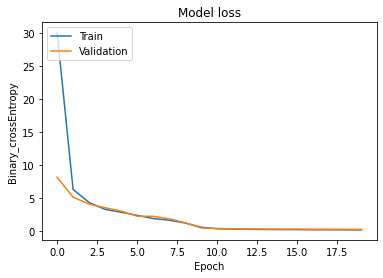

In [ ]:
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.title('Model dice coeff')
plt.ylabel('Dice coeff')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

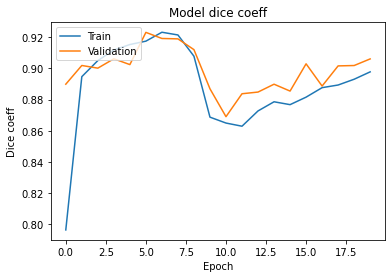

In [ ]:
plt.plot(history.history['jaccard_index'])
plt.plot(history.history['val_jaccard_index'])
plt.title('Model jaccard index')
plt.ylabel('Jaccard index')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

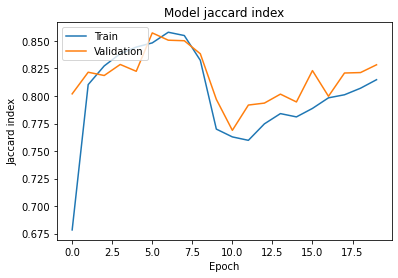